# 1. 2D CNN으로 1채널 MNIST 숫자 10개 분류하기

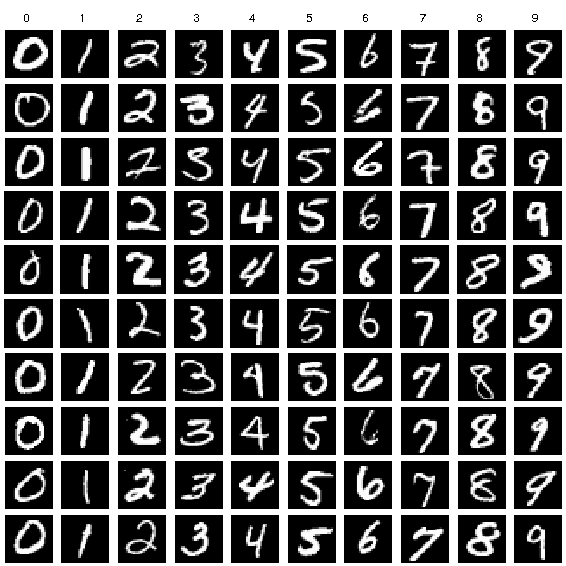

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# 만약 GPU를 사용 가능하다면 device 값이 cuda가 되고, 아니라면 cpu.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

learning_rate = 0.001
training_epochs = 15
batch_size = 100

# 데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의해줍니다.

mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, \
                                          shuffle=True,drop_last=True)

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # L1 Img shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # L2 Img shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # L3 Img shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # 자비에 초기화 적용
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)



        self.fc1 = torch.nn.Linear(2048, 625, bias=True)
        #self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)

        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5))

        self.fc2 = torch.nn.Linear(625, 10, bias=True)

        # Weight initialization
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        print("사이즈:", out.shape)
        out = self.layer4(out)
        out = self.fc2(out)
        return out


# CNN 모델 정의
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # 이미지는 (28x28)로 들어갑니다.
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        writer.add_scalar("Loss/train", cost, epoch)
        cost.backward()
        optimizer.step()

        avg_cost += cost / len(data_loader)

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

writer.flush()

###★ 재밌는 실습) 누군가가 학습 코드를 망가뜨려 놓았다. 잘 돌아가도록 코드를 수정하시오.

1. 자비에 weight init, 랜덤시드는 일부로 제거. 안넣어도 된다.

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 0.001
training_epochs = 15
batch_size = 100

mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True,drop_last=True)

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(     , 32, kernel_size=3, stride=1, padding=1),        # 수정
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,     , kernel_size=3, stride=1, padding=1),          # 수정
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        self.fc1 = torch.nn.Linear(      , 625, bias=True)                        # 수정

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5))

        self.fc2 = torch.nn.Linear(625, 10, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

# CNN 모델 정의
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # 이미지는 (28x28)로 들어갑니다.
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / len(data_loader)

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

# CNN 이미지 증강법

In [ ]:
# https://www.kaggle.com/datasets/tongpython/cat-and-dog/?select=test_set

In [ ]:
#!unzip training_set.zip

In [ ]:
#!unzip test_set.zip

In [ ]:
#!rm -r /content/test_set/cats/.ipynb_checkpoints
#!rm -r /content/test_set/dogs/.ipynb_checkpoints
#!rm -r /content/training_set/cats/.ipynb_checkpoints
#!rm -r /content/training_set/dogs/.ipynb_checkpoints

# 오프라인 데이터 증강(Offline Data augmentation) - albumentations

In [ ]:
# https://github.com/albumentations-team/albumentations

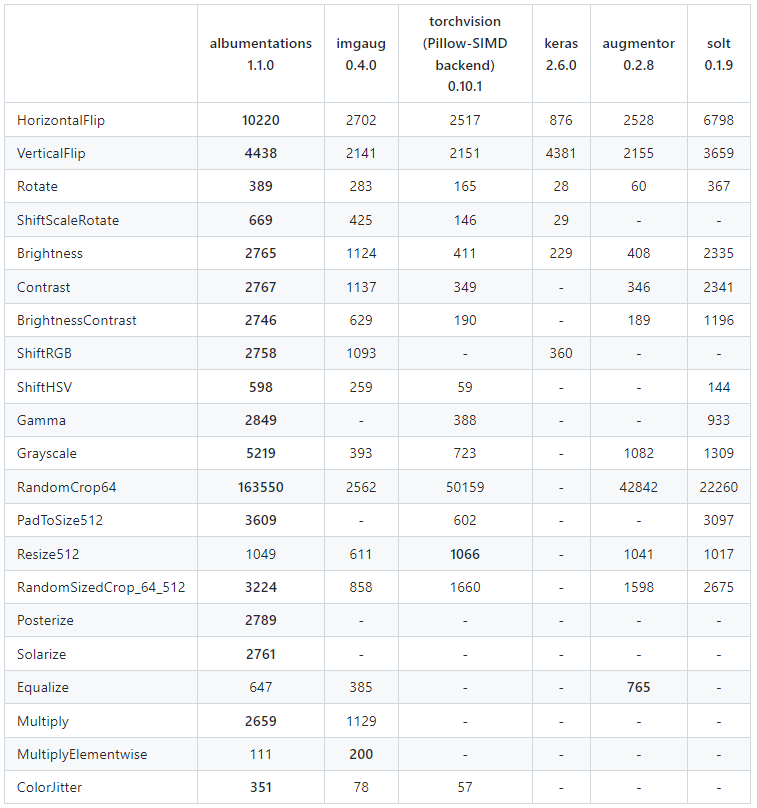

In [ ]:
!sudo rm -r training_set

In [ ]:
!gdown --id 1iog5aaxqS_U9sOPPAgdIIly8pxSZ1Cf7

In [ ]:
!unzip 개고양이.zip

Archive:  개고양이.zip
  inflating: training_set/cats/cat.1.jpg  
  inflating: training_set/cats/cat.10.jpg  
  inflating: training_set/cats/cat.100.jpg  
  inflating: training_set/cats/cat.11.jpg  
  inflating: training_set/cats/cat.12.jpg  
  inflating: training_set/cats/cat.13.jpg  
  inflating: training_set/cats/cat.14.jpg  
  inflating: training_set/cats/cat.15.jpg  
  inflating: training_set/cats/cat.16.jpg  
  inflating: training_set/cats/cat.17.jpg  
  inflating: training_set/cats/cat.18.jpg  
  inflating: training_set/cats/cat.19.jpg  
  inflating: training_set/cats/cat.2.jpg  
  inflating: training_set/cats/cat.20.jpg  
  inflating: training_set/cats/cat.21.jpg  
  inflating: training_set/cats/cat.22.jpg  
  inflating: training_set/cats/cat.23.jpg  
  inflating: training_set/cats/cat.24.jpg  
  inflating: training_set/cats/cat.25.jpg  
  inflating: training_set/cats/cat.26.jpg  
  inflating: training_set/cats/cat.27.jpg  
  inflating: training_set/cats/cat.28.jpg  
  inflating: t

In [ ]:
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image

image = plt.imread('/content/training_set/dogs/dog.1.jpg')

transform = A.Compose([
    A.Resize(256, 256),
    A.Blur(p=0.5),
    #A.HorizontalFlip(p=1),
])

transformed = transform(image=image) # 변형
transformed_image = transformed['image'] # transformed에서 이미지가 변환되고 난 결과를
                                         # image key에 저장되어있음.
im = Image.fromarray(transformed_image)
im.save("test.jpg")
plt.imshow(transformed_image)
plt.xticks([]); plt.yticks([])
plt.show()

In [ ]:
import os


transform = A.Compose([
  A.Resize(256, 256),
  A.Blur(p=0.5),
  #A.HorizontalFlip(p=1),
])

if not path.exists("./aug"):
  os.mkdir("./aug")

classes = os.listdir("./training_set")
for label in range(len(classes)):
    class_folder = os.path.join("./training_set",classes[label])
    for filename in os.listdir(class_folder):
        img_path = os.path.join(class_folder, filename)
        image = plt.imread(img_path)
        transformed = transform(image=image)
        transformed_image = transformed['image']
        im = Image.fromarray(transformed_image)
        im.save("./aug/"+"trans_"+filename)


# 3채널 CNN 모델 학습

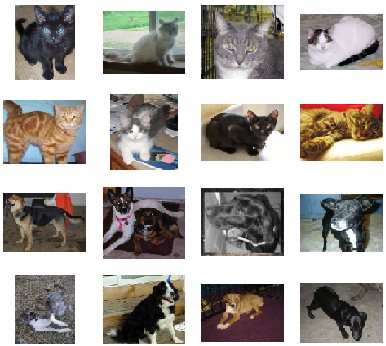

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from PIL import Image
import torchvision.transforms as T

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
data_dir = "."  # 현재 작업 디렉토리로 설정
batch_size = 32
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = CustomDataset(os.path.join(data_dir, 'training_set'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(os.path.join(data_dir, 'test_set'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(56 * 56 * 64, 2, bias=True)

        # FC층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

In [ ]:
# CNN 모델 정의
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


torch.save(model.state_dict(), 'cnn_model.pth')

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')

# Resnet18 파인튜닝 -  ImageNet 데이터셋(1400만장, 1000개의 서로 다른 객체 클래스)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

data_dir = "."
batch_size = 32
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = CustomDataset(os.path.join(data_dir, 'training_set'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(os.path.join(data_dir, 'test_set'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#model = models.densenet121(pretrained=True)
#model.classifier = torch.nn.Linear(model.classifier.in_features, len(train_dataset.classes))
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

#model = models.resnext50_32x4d(pretrained=True)
#model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

torch.save(model.state_dict(), 'resnet_model.pth')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []
        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        return image, label

data_dir = "."
batch_size = 32
processor = ViTImageProcessor(size=224, resample=Image.BILINEAR)
train_dataset = CustomDataset(os.path.join(data_dir, 'training_set'))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: batch)
test_dataset = CustomDataset(os.path.join(data_dir, 'test_set'))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: batch)

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(train_dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        images, labels = zip(*batch)
        encodings = processor(images, return_tensors='pt', padding=True, truncation=True)
        inputs = encodings['pixel_values'].to(device)
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

torch.save(model.state_dict(), 'vit_model.pth')

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = zip(*batch)
        encodings = processor(images, return_tensors='pt', padding=True, truncation=True)
        inputs = encodings['pixel_values'].to(device)
        labels = torch.tensor(labels).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.8102940533842359
Epoch 2/10, Loss: 0.6909511685371399
Epoch 3/10, Loss: 0.652228159563882
Epoch 4/10, Loss: 0.7871431452887399
Epoch 5/10, Loss: 0.704626338822501
Epoch 6/10, Loss: 0.6913056118147713
Epoch 7/10, Loss: 0.6938578316143581
Epoch 8/10, Loss: 0.6939310686928886
Epoch 9/10, Loss: 0.6941666007041931
Epoch 10/10, Loss: 0.6960157837186541
Accuracy on test set: 50.0%


# 실습) 아이리스 이미지 데이터로 분류 해보기